In [128]:
# @title CIFAR10 Classifier
import torch
import torch.nn as nn

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

net = CIFAR10Classifier()
print(net)


CIFAR10Classifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3):

Files already downloaded and verified
Files already downloaded and verified


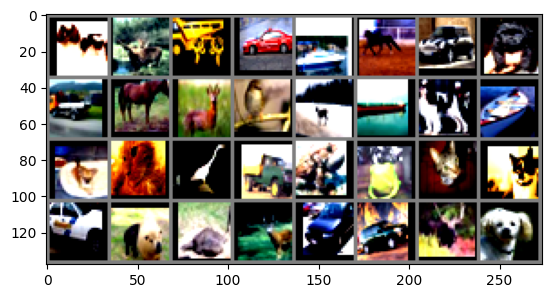

dog deer truck automobile ship horse automobile dog


In [121]:
# @title Datasets
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

transforms_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms_train)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

classes = train_dataset.dataset.classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(8)))


In [122]:
# @title Early Stopping
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).")
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [126]:
# @title Train Model
from tqdm import tqdm

def train_model(net, device, train_loader, val_loader, optimizer, criterion, num_epochs=50, patience=4, path='best_model.pth'):
    print(device)

    net.to(device)

    train_losses, val_losses, train_accuracy, val_accuracy = [], [], [], []

    early_stopping = EarlyStopping(patience=patience, verbose=True, path=path)

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy.append(100 * train_correct / train_total)

        net.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy.append(100 * val_correct / val_total)
        print(f"Train Accuracy: {train_accuracy[-1]:.2f}%")
        print(f"Validation Accuracy: {val_accuracy[-1]:.2f}%")
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        early_stopping(val_losses[-1], net)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    torch.save(net.state_dict(), path)

    return train_losses, val_losses, train_accuracy, val_accuracy


In [129]:
# @title Train Script
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

train_losses, val_losses, train_accuracy, val_accuracy = train_model(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
)

print(train_losses, val_losses)

cuda


Epoch 1/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.00it/s]


Train Accuracy: 31.64%
Validation Accuracy: 42.04%
Epoch 1: Train Loss = 2.1543, Val Loss = 2.0452
Validation loss decreased (inf --> 2.045234). Saving model ...


Epoch 2/50: 100%|██████████| 1250/1250 [00:07<00:00, 167.46it/s]


Train Accuracy: 44.91%
Validation Accuracy: 47.44%
Epoch 2: Train Loss = 2.0194, Val Loss = 1.9910
Validation loss decreased (2.045234 --> 1.990969). Saving model ...


Epoch 3/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.02it/s]


Train Accuracy: 50.77%
Validation Accuracy: 55.06%
Epoch 3: Train Loss = 1.9607, Val Loss = 1.9176
Validation loss decreased (1.990969 --> 1.917564). Saving model ...


Epoch 4/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.50it/s]


Train Accuracy: 55.29%
Validation Accuracy: 59.16%
Epoch 4: Train Loss = 1.9163, Val Loss = 1.8794
Validation loss decreased (1.917564 --> 1.879369). Saving model ...


Epoch 5/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.31it/s]


Train Accuracy: 58.12%
Validation Accuracy: 59.14%
Epoch 5: Train Loss = 1.8869, Val Loss = 1.8761
Validation loss decreased (1.879369 --> 1.876122). Saving model ...


Epoch 6/50: 100%|██████████| 1250/1250 [00:07<00:00, 169.43it/s]


Train Accuracy: 60.53%
Validation Accuracy: 62.63%
Epoch 6: Train Loss = 1.8626, Val Loss = 1.8403
Validation loss decreased (1.876122 --> 1.840296). Saving model ...


Epoch 7/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.41it/s]


Train Accuracy: 62.15%
Validation Accuracy: 63.81%
Epoch 7: Train Loss = 1.8451, Val Loss = 1.8290
Validation loss decreased (1.840296 --> 1.829049). Saving model ...


Epoch 8/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.69it/s]


Train Accuracy: 63.99%
Validation Accuracy: 65.88%
Epoch 8: Train Loss = 1.8274, Val Loss = 1.8054
Validation loss decreased (1.829049 --> 1.805385). Saving model ...


Epoch 9/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.25it/s]


Train Accuracy: 65.14%
Validation Accuracy: 66.92%
Epoch 9: Train Loss = 1.8146, Val Loss = 1.7983
Validation loss decreased (1.805385 --> 1.798277). Saving model ...


Epoch 10/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.18it/s]


Train Accuracy: 66.20%
Validation Accuracy: 67.49%
Epoch 10: Train Loss = 1.8023, Val Loss = 1.7889
Validation loss decreased (1.798277 --> 1.788883). Saving model ...


Epoch 11/50: 100%|██████████| 1250/1250 [00:07<00:00, 177.57it/s]


Train Accuracy: 67.41%
Validation Accuracy: 68.53%
Epoch 11: Train Loss = 1.7919, Val Loss = 1.7792
Validation loss decreased (1.788883 --> 1.779232). Saving model ...


Epoch 12/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.37it/s]


Train Accuracy: 68.21%
Validation Accuracy: 69.53%
Epoch 12: Train Loss = 1.7829, Val Loss = 1.7701
Validation loss decreased (1.779232 --> 1.770086). Saving model ...


Epoch 13/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.48it/s]


Train Accuracy: 68.92%
Validation Accuracy: 69.24%
Epoch 13: Train Loss = 1.7747, Val Loss = 1.7717
EarlyStopping counter: 1 out of 4


Epoch 14/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.78it/s]


Train Accuracy: 69.90%
Validation Accuracy: 70.60%
Epoch 14: Train Loss = 1.7665, Val Loss = 1.7577
Validation loss decreased (1.770086 --> 1.757694). Saving model ...


Epoch 15/50: 100%|██████████| 1250/1250 [00:07<00:00, 167.09it/s]


Train Accuracy: 70.44%
Validation Accuracy: 70.51%
Epoch 15: Train Loss = 1.7592, Val Loss = 1.7578
EarlyStopping counter: 1 out of 4


Epoch 16/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.13it/s]


Train Accuracy: 71.09%
Validation Accuracy: 71.94%
Epoch 16: Train Loss = 1.7537, Val Loss = 1.7447
Validation loss decreased (1.757694 --> 1.744740). Saving model ...


Epoch 17/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.80it/s]


Train Accuracy: 71.66%
Validation Accuracy: 72.41%
Epoch 17: Train Loss = 1.7472, Val Loss = 1.7427
Validation loss decreased (1.744740 --> 1.742734). Saving model ...


Epoch 18/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.62it/s]


Train Accuracy: 71.96%
Validation Accuracy: 72.86%
Epoch 18: Train Loss = 1.7441, Val Loss = 1.7362
Validation loss decreased (1.742734 --> 1.736202). Saving model ...


Epoch 19/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.93it/s]


Train Accuracy: 72.66%
Validation Accuracy: 73.63%
Epoch 19: Train Loss = 1.7379, Val Loss = 1.7279
Validation loss decreased (1.736202 --> 1.727881). Saving model ...


Epoch 20/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.23it/s]


Train Accuracy: 73.23%
Validation Accuracy: 72.98%
Epoch 20: Train Loss = 1.7310, Val Loss = 1.7339
EarlyStopping counter: 1 out of 4


Epoch 21/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.49it/s]


Train Accuracy: 73.42%
Validation Accuracy: 72.96%
Epoch 21: Train Loss = 1.7292, Val Loss = 1.7319
EarlyStopping counter: 2 out of 4


Epoch 22/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.53it/s]


Train Accuracy: 73.59%
Validation Accuracy: 72.70%
Epoch 22: Train Loss = 1.7273, Val Loss = 1.7347
EarlyStopping counter: 3 out of 4


Epoch 23/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.43it/s]


Train Accuracy: 74.14%
Validation Accuracy: 74.28%
Epoch 23: Train Loss = 1.7221, Val Loss = 1.7219
Validation loss decreased (1.727881 --> 1.721891). Saving model ...


Epoch 24/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.36it/s]


Train Accuracy: 74.76%
Validation Accuracy: 73.94%
Epoch 24: Train Loss = 1.7171, Val Loss = 1.7223
EarlyStopping counter: 1 out of 4


Epoch 25/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.89it/s]


Train Accuracy: 75.12%
Validation Accuracy: 74.57%
Epoch 25: Train Loss = 1.7134, Val Loss = 1.7157
Validation loss decreased (1.721891 --> 1.715683). Saving model ...


Epoch 26/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.46it/s]


Train Accuracy: 75.27%
Validation Accuracy: 74.21%
Epoch 26: Train Loss = 1.7103, Val Loss = 1.7197
EarlyStopping counter: 1 out of 4


Epoch 27/50: 100%|██████████| 1250/1250 [00:06<00:00, 178.99it/s]


Train Accuracy: 75.55%
Validation Accuracy: 75.19%
Epoch 27: Train Loss = 1.7081, Val Loss = 1.7103
Validation loss decreased (1.715683 --> 1.710278). Saving model ...


Epoch 28/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.87it/s]


Train Accuracy: 75.92%
Validation Accuracy: 74.97%
Epoch 28: Train Loss = 1.7047, Val Loss = 1.7119
EarlyStopping counter: 1 out of 4


Epoch 29/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.58it/s]


Train Accuracy: 76.04%
Validation Accuracy: 75.71%
Epoch 29: Train Loss = 1.7030, Val Loss = 1.7056
Validation loss decreased (1.710278 --> 1.705608). Saving model ...


Epoch 30/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.22it/s]


Train Accuracy: 76.28%
Validation Accuracy: 76.01%
Epoch 30: Train Loss = 1.7010, Val Loss = 1.7033
Validation loss decreased (1.705608 --> 1.703261). Saving model ...


Epoch 31/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.53it/s]


Train Accuracy: 76.72%
Validation Accuracy: 75.52%
Epoch 31: Train Loss = 1.6958, Val Loss = 1.7067
EarlyStopping counter: 1 out of 4


Epoch 32/50: 100%|██████████| 1250/1250 [00:07<00:00, 169.34it/s]


Train Accuracy: 77.11%
Validation Accuracy: 75.36%
Epoch 32: Train Loss = 1.6924, Val Loss = 1.7079
EarlyStopping counter: 2 out of 4


Epoch 33/50: 100%|██████████| 1250/1250 [00:07<00:00, 172.63it/s]


Train Accuracy: 77.38%
Validation Accuracy: 76.90%
Epoch 33: Train Loss = 1.6898, Val Loss = 1.6940
Validation loss decreased (1.703261 --> 1.693964). Saving model ...


Epoch 34/50: 100%|██████████| 1250/1250 [00:07<00:00, 176.76it/s]


Train Accuracy: 77.33%
Validation Accuracy: 76.81%
Epoch 34: Train Loss = 1.6895, Val Loss = 1.6944
EarlyStopping counter: 1 out of 4


Epoch 35/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.47it/s]


Train Accuracy: 77.42%
Validation Accuracy: 76.62%
Epoch 35: Train Loss = 1.6888, Val Loss = 1.6945
EarlyStopping counter: 2 out of 4


Epoch 36/50: 100%|██████████| 1250/1250 [00:06<00:00, 178.81it/s]


Train Accuracy: 78.09%
Validation Accuracy: 76.93%
Epoch 36: Train Loss = 1.6829, Val Loss = 1.6925
Validation loss decreased (1.693964 --> 1.692490). Saving model ...


Epoch 37/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.41it/s]


Train Accuracy: 77.88%
Validation Accuracy: 77.40%
Epoch 37: Train Loss = 1.6842, Val Loss = 1.6887
Validation loss decreased (1.692490 --> 1.688664). Saving model ...


Epoch 38/50: 100%|██████████| 1250/1250 [00:07<00:00, 172.36it/s]


Train Accuracy: 78.19%
Validation Accuracy: 77.29%
Epoch 38: Train Loss = 1.6812, Val Loss = 1.6916
EarlyStopping counter: 1 out of 4


Epoch 39/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.62it/s]


Train Accuracy: 78.20%
Validation Accuracy: 77.80%
Epoch 39: Train Loss = 1.6814, Val Loss = 1.6850
Validation loss decreased (1.688664 --> 1.684969). Saving model ...


Epoch 40/50: 100%|██████████| 1250/1250 [00:07<00:00, 177.65it/s]


Train Accuracy: 78.83%
Validation Accuracy: 77.78%
Epoch 40: Train Loss = 1.6760, Val Loss = 1.6841
Validation loss decreased (1.684969 --> 1.684138). Saving model ...


Epoch 41/50: 100%|██████████| 1250/1250 [00:07<00:00, 177.84it/s]


Train Accuracy: 79.04%
Validation Accuracy: 78.12%
Epoch 41: Train Loss = 1.6735, Val Loss = 1.6816
Validation loss decreased (1.684138 --> 1.681614). Saving model ...


Epoch 42/50: 100%|██████████| 1250/1250 [00:07<00:00, 173.53it/s]


Train Accuracy: 78.94%
Validation Accuracy: 77.17%
Epoch 42: Train Loss = 1.6732, Val Loss = 1.6897
EarlyStopping counter: 1 out of 4


Epoch 43/50: 100%|██████████| 1250/1250 [00:07<00:00, 175.02it/s]


Train Accuracy: 79.08%
Validation Accuracy: 77.86%
Epoch 43: Train Loss = 1.6723, Val Loss = 1.6832
EarlyStopping counter: 2 out of 4


Epoch 44/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.09it/s]


Train Accuracy: 79.31%
Validation Accuracy: 78.66%
Epoch 44: Train Loss = 1.6700, Val Loss = 1.6762
Validation loss decreased (1.681614 --> 1.676167). Saving model ...


Epoch 45/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.36it/s]


Train Accuracy: 79.67%
Validation Accuracy: 78.15%
Epoch 45: Train Loss = 1.6661, Val Loss = 1.6804
EarlyStopping counter: 1 out of 4


Epoch 46/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.22it/s]


Train Accuracy: 79.42%
Validation Accuracy: 78.47%
Epoch 46: Train Loss = 1.6683, Val Loss = 1.6772
EarlyStopping counter: 2 out of 4


Epoch 47/50: 100%|██████████| 1250/1250 [00:07<00:00, 171.14it/s]


Train Accuracy: 79.81%
Validation Accuracy: 78.47%
Epoch 47: Train Loss = 1.6645, Val Loss = 1.6762
EarlyStopping counter: 3 out of 4


Epoch 48/50: 100%|██████████| 1250/1250 [00:07<00:00, 168.79it/s]


Train Accuracy: 80.01%
Validation Accuracy: 78.60%
Epoch 48: Train Loss = 1.6639, Val Loss = 1.6747
Validation loss decreased (1.676167 --> 1.674687). Saving model ...


Epoch 49/50: 100%|██████████| 1250/1250 [00:07<00:00, 170.20it/s]


Train Accuracy: 79.83%
Validation Accuracy: 78.59%
Epoch 49: Train Loss = 1.6638, Val Loss = 1.6752
EarlyStopping counter: 1 out of 4


Epoch 50/50: 100%|██████████| 1250/1250 [00:07<00:00, 174.28it/s]


Train Accuracy: 79.95%
Validation Accuracy: 79.23%
Epoch 50: Train Loss = 1.6632, Val Loss = 1.6711
Validation loss decreased (1.674687 --> 1.671067). Saving model ...
[2.154284772491455, 2.019432718753815, 1.9606773818016052, 1.916269400215149, 1.8869152220726013, 1.8625616549491881, 1.8450679333686828, 1.8274059470176698, 1.8145930804252624, 1.802319270324707, 1.7918981536865235, 1.7829346573829652, 1.7746891978263855, 1.766533466720581, 1.759158919429779, 1.7536748492240906, 1.7471543293952942, 1.7440582276344299, 1.7379004050254823, 1.7309868159294128, 1.7291689929008485, 1.727323638343811, 1.7221196410179138, 1.7171050738334657, 1.7133747182846069, 1.7102808636665345, 1.7080820168495179, 1.7046692147254945, 1.7030238298416138, 1.7009891572952271, 1.6958192058563233, 1.692399358177185, 1.6898373187065125, 1.6894722053527833, 1.6887519876480102, 1.682886883354187, 1.6842347541809082, 1.6811750999450683, 1.6813899918556214, 1.67599436378479, 1.6735030219078064, 1.673184848213196, 1.6

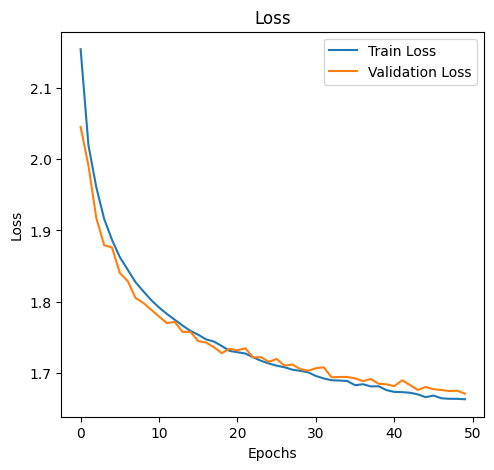

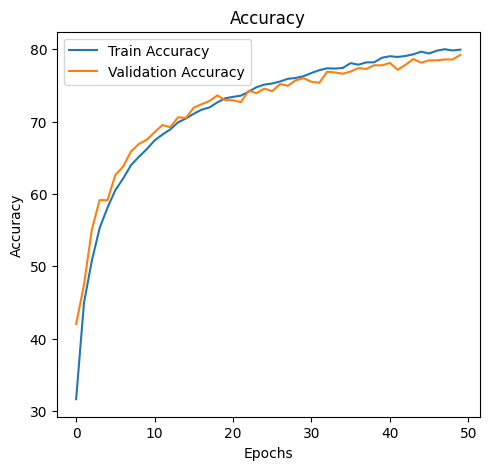

In [130]:
# @title Diagrams
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [131]:
# @title Test script
import os
if os.path.exists("best_model.pth"):
    net.load_state_dict(torch.load("best_model.pth"))
else:
    print("Model file not found!")
    exit()

net.eval()
test_loss = 0.0
correct = 0
total = 0
num_classes = 10
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

test_loss /= total
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

for i in range(num_classes):
    if class_total[i] > 0:
        print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Accuracy of class {i}: No samples")


<ipython-input-131-25f3318e4fa7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


Test Loss: 1.6521, Test Accuracy: 80.85%
Accuracy of class 0: 82.30%
Accuracy of class 1: 92.00%
Accuracy of class 2: 67.20%
Accuracy of class 3: 64.70%
Accuracy of class 4: 77.00%
Accuracy of class 5: 77.60%
Accuracy of class 6: 85.60%
Accuracy of class 7: 85.40%
Accuracy of class 8: 91.10%
Accuracy of class 9: 85.60%
